In [1]:
# Author: Sheila Sharifi
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

torch.manual_seed(99)
np.random.seed(99)

In [13]:
# Author: Weixiao Huang
## Notice: label for each bird species: Grey Partridge --0, Stock Dove -- 1, Turtle Dove -- 2, yellowhammer -- 3
## Notice: In order to import the entire dataset, you may need to combine the four files that each contain the song spectrograms of a different species of bird into one file called "datasets", 
# and alter the file's path to match your "datastes" directory. It can take about 20 minutes to import all 4000 of the spectrograms. 

temp = pd.DataFrame([[i for i in range(27648)]])
temp.insert(loc = 0, column = "label", value =0 )
print(temp)

path = "I:/datasets"

data_files = [f for f in os.listdir(path)]
print(data_files)

for data_file in data_files:
    added_path = os.path.join(path, data_file)
    files = [p for p in os.listdir(added_path) if not p.endswith(".csv")]
    for a in files: 
        added_path_1 = os.path.join(added_path, a)
        image_files = [i for i in os.listdir(added_path_1)]
        for b in image_files:
            full_path = os.path.join(added_path_1, b)
            image = Image.open(full_path)
            width, height = image.size
            if width == 216 and height == 128:
                pixels = list(image.getdata())
                if "greypartridge" in full_path:
                    # bird species is grey partridge
                    label = 0
                elif "stockdove" in full_path:
                    # bird species is Stock Dove
                    label = 1
                elif "turtledove" in full_path:
                    # bird species is Turtle Dove
                    label = 2
                else:
                    # bird species is yellow hammer
                    label = 3
                pixels_labeled = [label]+pixels
                temp.loc[len(temp)] = pixels_labeled
            else:
                continue
#                 print("width is not 216, hence filtered out")
                
data = temp.iloc[1:]
print(f"data: \n{data}")    
labels = data.loc[:,"label"]

# 479 images have been filtered due to the inconsistency dimensions

   label  0  1  2  3  4  5  6  7  8  ...  27638  27639  27640  27641  27642  \
0      0  0  1  2  3  4  5  6  7  8  ...  27638  27639  27640  27641  27642   

   27643  27644  27645  27646  27647  
0  27643  27644  27645  27646  27647  

[1 rows x 27649 columns]
['greypartridge', 'stockdove', 'turtledove', 'yellowhammer']
data: 
      label    0    1    2    3    4    5    6    7    8  ...  27638  27639  \
1         0  212  234  240  233  233  227  235  235  229  ...     20     31   
2         0  173  233  213  241  227  242  234  244  241  ...     30     47   
3         0  201  244  236  230  236  235  224  231  230  ...     79     27   
4         0  184  232  231  225  208  228  243  234  225  ...     26     52   
5         0  169  245  247  233  241  237  238  236  241  ...     11      3   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
3517      3  255  229  190  197  215  191  191  204  204  ...     47     28   
3518      3  194  213  199  214  221 

# Train Test Split

In [24]:
# Author: Anuj Solanki
train_df,test_df = train_test_split(data,test_size=0.2, stratify= labels)

train_data = torch.tensor(train_df.iloc[:, 1:].to_numpy(dtype = 'float32')/255)
test_data = torch.tensor(test_df.iloc[:, 1:].to_numpy(dtype = 'float32')/255)
train_labels = torch.tensor(train_df['label'].values).long()
test_labels = torch.tensor(test_df['label'].values).long()
print(f"Train data size : {train_data.shape}")
print(f"Test data size : {test_data.shape}")


Train data size : torch.Size([2816, 27648])
Test data size : torch.Size([705, 27648])


In [25]:
# Author: Sheila Sharifi
train_images = train_data.reshape(-1,1,128,216)
test_images = test_data.reshape(-1,1,128,216)


In [26]:
# Author: Weixiao Huang
train_dataset = TensorDataset(train_images,train_labels)
test_dataset = TensorDataset(test_images,test_labels)

batch_size = 64 

train_loader = DataLoader(train_dataset, batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size,shuffle=False )

In [27]:
# Author: Weixiao Huang & Sristi Jaiswal 
num_classes = 4

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn = nn.Sequential(

            nn.Conv2d(1, 16, 3, stride = 1, padding = 1), # kernel size of 3 means 3x3
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),  # prevent overfitting
            nn.ReLU(),
            nn.Flatten(),
            
            nn.Dropout(0.4),
            nn.Linear(55296, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_classes)
            )
        

    def forward(self, x):
        out = self.cnn(x)
      
        return out


In [38]:
# Author: Sristi Jaiswal 
num_epochs = 10

def train(model,train_loader,test_loader,num_epochs,optimizer):
    criterion = nn.CrossEntropyLoss()
    
    epochs, epoch_loss, epoch_val_loss, epoch_accuracy= [],[],[],[]
    for n in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx,(data,labels) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        train_loss = train_loss/(batch_idx+1)
        epoch_loss.append(train_loss)
        model.eval()  
        correct = 0
        total = 0
        loss_list = []
        with torch.no_grad():
            for batch_idx,(data,labels) in enumerate(test_loader):
                outputs = model(data)
                loss = criterion(outputs, labels)
                loss_list.append(loss)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += len(labels)
                
        val_loss = np.mean(loss_list)
        epoch_val_loss.append(val_loss)
        accuracy = correct/total  
        epoch_accuracy.append(accuracy*100)
        epochs.append(n+1)
        print(f'{n+1} / {num_epochs}: loss {train_loss:0.03f}, val_loss {val_loss:0.03f}, accuracy {accuracy:0.03f}')
        
    fig,axs = plt.subplots(1,2,figsize=(16,5))
    axs[0].plot(epochs,epoch_loss,label='train')
    axs[0].plot(epochs,epoch_val_loss,label='val')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[1].plot(epochs,epoch_accuracy)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')


In [44]:
# Author: Anuj Solanki
loss_fn = nn.CrossEntropyLoss()
def test(model, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    model.eval()
    test_loss = 0
    correct = 0
    
    label_array = np.zeros(len(test_dataset))
    pred_array = np.zeros(len(test_dataset))
    n=0
    with torch.no_grad():
        for images, labels in test_loader:
            pred = model(images)
            pred_labels = pred.argmax(1)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred_labels == labels).sum().item()

            for label, prediction in zip(labels, pred_labels):
                
                label_array[n] = label
                pred_array[n] = prediction
                n=n+1
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return label_array, pred_array

torch.Size([64, 4])
1 / 10: loss 2.099, val_loss 0.869, accuracy 0.664
2 / 10: loss 0.787, val_loss 0.664, accuracy 0.762
3 / 10: loss 0.641, val_loss 0.576, accuracy 0.796
4 / 10: loss 0.569, val_loss 0.525, accuracy 0.799
5 / 10: loss 0.529, val_loss 0.489, accuracy 0.834
6 / 10: loss 0.489, val_loss 0.477, accuracy 0.828
7 / 10: loss 0.464, val_loss 0.469, accuracy 0.823
8 / 10: loss 0.443, val_loss 0.489, accuracy 0.818
9 / 10: loss 0.411, val_loss 0.434, accuracy 0.835
10 / 10: loss 0.381, val_loss 0.429, accuracy 0.837


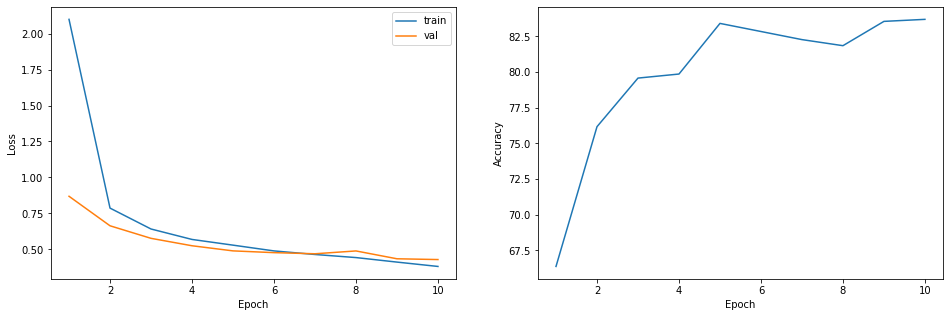

In [46]:
# Author: Sristi Jaiswal 
model = CNN()

for images,label in train_loader:
    output = model(images)
print(output.shape)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-3)
train(model,train_loader,test_loader,num_epochs,optimizer)


Test Error: 
 Accuracy: 83.7%, Avg loss: 0.428886 



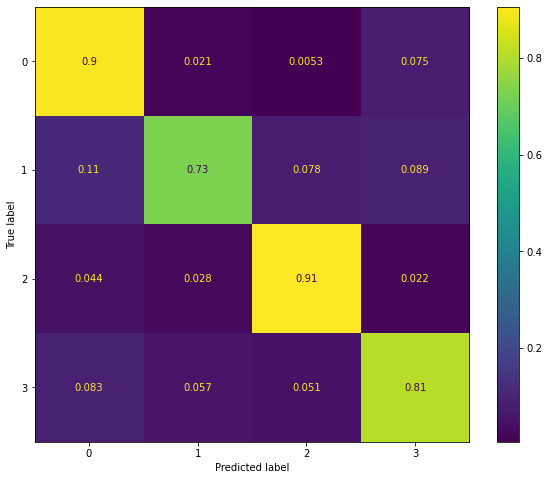

In [47]:
# Author: Anuj Solanki
classes = [0,1,2,3]

label_array, pred_array = test(model,loss_fn)

from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(label_array, pred_array,
                display_labels=classes,
                normalize='true')
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(10)